# INF283 | Weekly Exercise 04 | Support Vector Machines and Ensemble Learning

#### Deadline
October 05, 2018 | 23:59

#### What to deliver 
You can try out your Python code within this notebook. But you should <font color="#b51555">make a PDF file of answers for each of the tasks, and then submit this PDF file </font>on Mitt UiB.  <font color="#b51555">**Do not submit the complete notebook; it makes it difficult for the graders to locate your answers in the lengthy Jupyter notebook. **</font>

#### Where to deliver
On [Mitt UiB](https://mitt.uib.no/courses/12791/assignments) in the assignments section.

#### Note to students
This is a Python notebook and all the examples are in Python. You are free to use any programming language you want to do the exercise questions in; we will grade your submissions. But, if you got stuck somewhere, we can provide help for Python only. Moreover, the solution provided after the deadline will also in be in Python.

In case you want to learn Python, you can quickly learn it using these [set of short videos](https://www.youtube.com/watch?v=oVp1vrfL_w4&list=PLQVvvaa0QuDe8XSftW-RAxdo6OmaeL85M).

# 1. Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [31]:
# one time installation  only
!pip install ipywidgets
!pip install seaborn

In [110]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt


# Use seaborn plotting defaults
# Without these defaults, the plots would be a bit uglier
import seaborn as sns; sns.set()

# Some code (such as the code to do PCA) will generate useless warnings
# We will suppress these warning using the code below
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Generating data

Consider the simple case of a classification task, in which the two classes of points are well separated. Lets generate data for such two classes:

Text(0,0.5,'$x_1$')

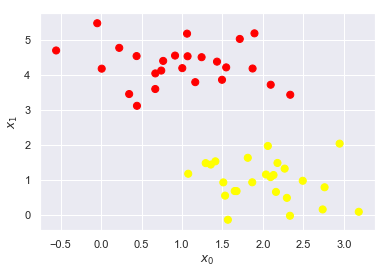

In [111]:
from sklearn.datasets.samples_generator import make_blobs
# Create 50 (n_samples=50) datapoints clustered together as two (center=2) blobs
# The within-cluster spread (cluster_std=0.60) of the datapoints is 0.6
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

# Each datapoint in X is tuple of values (x0, x1). Lets plot them 
# on x and y axes respectively.
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")

---


## <font color="#b51555">Exercise 1.1

1. Write the code to find the dimensions of vector `X`
2. Write the code to find the dimension of the vector `y` 
3. What does the vector `y` contain, and what do these values of `y` represent?
<font>

---



In [112]:
#1.
print("Dimensions of X:", X.shape)

#2.
print("Dimension of y:", y.ndim)

#3.
#The vector y contains the classifiers, 
#divided into two groups of zeros and ones.

Dimensions of X: (50, 2)
Dimension of y: 1


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

0.65
1.6
2.9


Text(0,0.5,'x1')

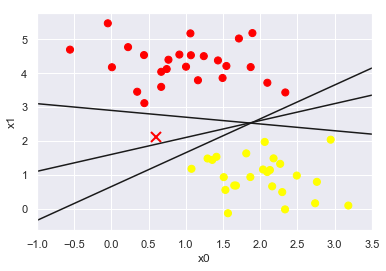

In [113]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
    print(b)

plt.xlim(-1, 3.5);
plt.xlabel('x0')
plt.ylabel('x1')

---
## <font color="#b51555">Exercise 1.2
What are `m` and `b` in the `for` loop above? What do they represent?
<font>
  
---

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

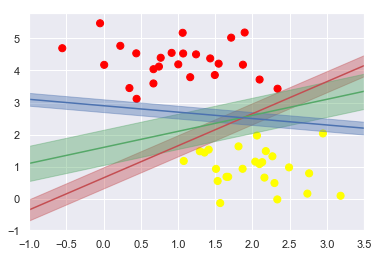

In [114]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d, col in [(1, 0.65, 0.33, 'r'), (0.5, 1.6, 0.55, 'g'), (-0.2, 2.9, 0.2, 'b')]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k', color=col)
    plt.fill_between(xfit, yfit - d, yfit + d, 
                     edgecolor='none',
                     color=col, alpha=0.4)
    
plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.


---
## <font color="#b51555">Exercise 1.3


What is `d` in the code above. What does it represent?
<font>

---

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [115]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)


SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries and highlight the support vectors  for us :

In [116]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot a black dot over the support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 20, facecolor= 'black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


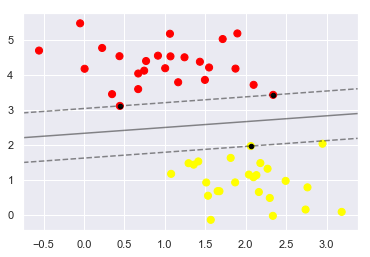

In [117]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, plot_support=True);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier.



---
## <font color="#b51555">Exercise 1.4

1. Write the code to print out the value of support vectors.
2. How many support vectors are there in the model above?
<font>

---



In [118]:
#1.
print(model.support_vectors_)

print("There are ", len(model.support_vectors_), " support vectors")

#2.
print("Vectors divided in", model.n_support_[0], "red and",
      model.n_support_[1], "yellow")

[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]
There are  3  support vectors
Vectors divided in 2 red and 1 yellow


A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

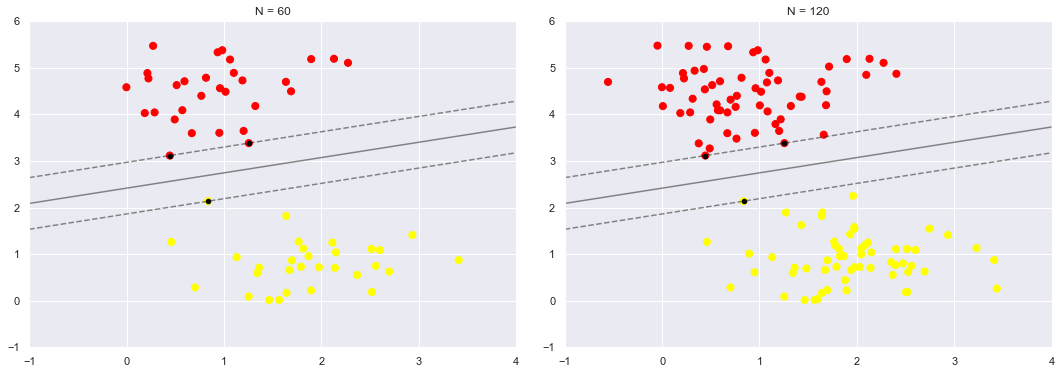

In [119]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [120]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 20, 30, 50, 100, 150, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 30, 50, 100, 150, 200), value=10), Output()),…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of  Linear Regression. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

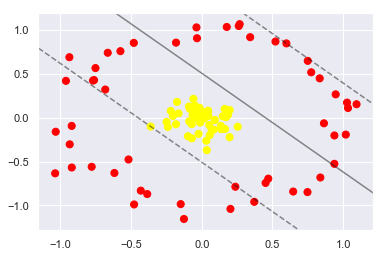

In [121]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in Linear Regression and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [123]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [124]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x_0')
    ax.set_ylabel('x_1')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90, 5), azim=(-180, 180, 5),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90, step=5), IntSlider(value=30, de…

---
## <font color="#b51555">Exercise 1.5
In the section above, we transformed the data from ${\rm I\!R^2}$ to ${\rm I\!R^3}$ using a third dimension `r`. `r` was obtained by transforming X using a radial basis function. Radial basis function must be centered at some point when calculating them (as you may observed in the Linear Regression assignment). So at which point did we center the `r` while calculating it?
<font>
  
---

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.



One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [125]:
clf = SVC(kernel='rbf', C=1E6, probability=True)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

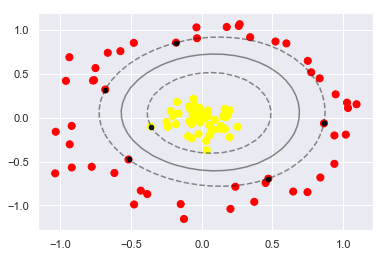

In [126]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

---
## <font color="#b51555">Exercise 1.6
1. Suppose a new point `[0.5, 0]` comes along. Will it be classified as being belong to the `yellow` class or the `red` class. Write the code to classify this point using the model we just trained.
2. What is the probability of this point `[0.5, 0]` belonging to the `yellow` class.
 <font>
  
---


In [132]:
point = [0.5 , 0]

#1.
print("The point", point, "will be classified as", clf.predict([[0.5, 0]]))
print()

#2.
prob0 = clf.predict_proba([point])[0][0]*100
prob1 = clf.predict_proba([point])[0][1]*100
print("Probability of %.2f" % prob0, 
      "% that it will be belonging to the red class")
print("Probability of %.2f" % prob1, 
      "% that it will be belonging to the yellow class")

The point [0.5, 0] will be classified as [1]

Probability of 12.05 % that it will be belonging to the red class
Probability of 87.95 % that it will be belonging to the yellow class


##### NOTE:
An SVM classifier, the way it works, cannot give probabilistic information about the class label that it predict. However, there is a work around for it. This method computes the probability that a given datapoint belongs to a particular class using Platt scaling. If you are interested in how Platt Scaling works, then visit this [link](https://prateekvjoshi.com/2015/12/15/how-to-compute-confidence-measure-for-svm-classifiers/).

We specified in the code  (using `probability=True` parameter) that we want the SVM to calculate the class probabilities.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

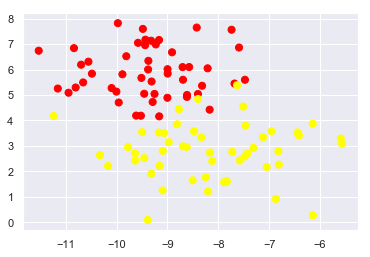

In [133]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=34, cluster_std=1.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

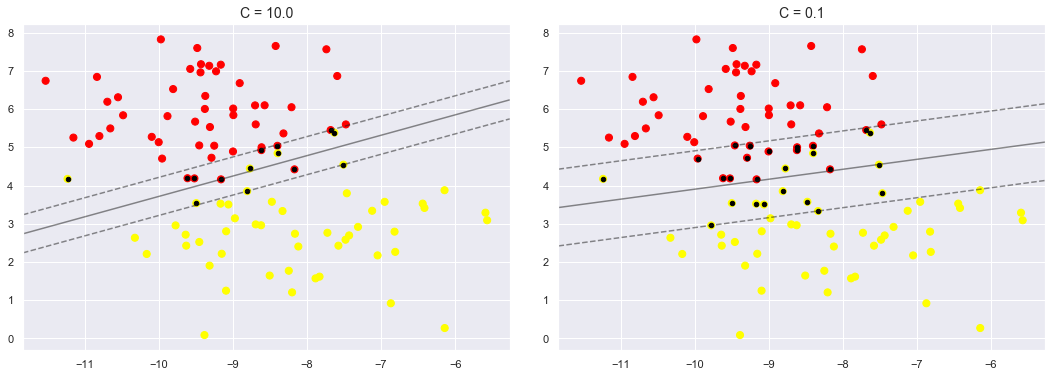

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.set_title('C = {0:.1f}'.format(C), size=14)

---
## <font color="#b51555">Exercise 1.7
How can we know what is the best value of C? What can you do find the best value of C?
 <font>
  
---

## Kernel Trick
The Trick in the Kernel Trick is to avoid mapping features from low dimensions to high dimensions, thus avoiding computationally intensive operations.

We will now try to elaborate this point with an example. 

Let us first generate a large dummy dataset `x`, and a data point `z`:





In [135]:
x, _ = make_blobs(n_samples=100000, centers=2, random_state=0, cluster_std=1.2)
z = np.array([0.1, 0.2])


Now, we will write two functions:

**1. `calculate_dot_product_in_higher_dimensional_space`**

This function first transforms `x` and `z` in the higher dimensional space using the following transform:
$$
\phi(x) = (x_1^2, x_2^2, \sqrt2 x_1 x_2)
$$

$$
\phi(z) = (z_1^2, z_2^2, \sqrt2 z_1 z_2)
$$

and then calculates the dot product of $\phi(x)$ and $\phi(z)$

**2. `calculate_dot_product_in_lower_dimensional_space_with_kernel_trick`**

This second function will do the same job as the first one, but it will do it much more efficient without
having to the transform the data into the higher dimensional space first. It uses the kernel trick to get the same results as the first function but in a fraction of time of the first function.


In [137]:
def calculate_dot_product_in_higher_dimensional_space(x, z):
  """
  This function calculates the dot product of x and z in higher 
  dimensional space. This function is highly inefficient.
  """
  
  #----------------------------------------------------------------------------#
  # Step 1: Transform the data explicitly in higher dimensional space
  #----------------------------------------------------------------------------#
  
  # transform x into higher dimensional space
  transformed_x = np.ndarray(shape=(x.shape[0], x.shape[1]+1))
  for i in range(x.shape[0]):
    transformed_x[i] = np.array([x[i][0]*x[i][0], 
                                 x[i][1]*x[i][1], 
                                 sqrt(2)*x[i][0]*x[i][1]])
  # transform z into higher dimensional space
  transformed_z = np.array([[z[0]*z[0]], 
                            [z[1]*z[1]], 
                            [sqrt(2)*z[0]*z[1]]])
  
  
  #----------------------------------------------------------------------------#
  # Step 2: Take dot product between each row of transformed_x & transformed_z
  #----------------------------------------------------------------------------#

  dot_product = np.ndarray(shape=(transformed_x.shape[0], 1))
  for i in range(transformed_x.shape[0]):
    dot_product[i] = transformed_x[i].T.dot(transformed_z)  
  
  return dot_product


def calculate_dot_product_in_lower_dimensional_space_with_kernel_trick(x, z):
  """ 
  This function calculates the dot product of x and z in lower dimensional 
  space (without projecting the data in higher dimensional space first)
  using the Kernel trick.
  """
  
  #----------------------------------------------------------------------------#
  # Step 1: Take dot product of x.T and z in lower dimensional space
  #----------------------------------------------------------------------------#
  dot_product = x.dot(z)

  #----------------------------------------------------------------------------#
  # Step 2: Square the dot product and return
  #----------------------------------------------------------------------------#
  return dot_product**2
    

Let us now run both the functions:

In [138]:
#1.
import time
start_timeA = time.time()
a = calculate_dot_product_in_higher_dimensional_space(x, z)
print("Time a: %0.10f seconds" % (time.time() - start_timeA))

start_timeB = time.time()
b = calculate_dot_product_in_lower_dimensional_space_with_kernel_trick(x, z)

print("Time b: %0.10f seconds" % (time.time() - start_timeB))

Time a: 0.7550382614 seconds
Time b: 0.0019989014 seconds


Now we will compare the output of the two function to check if they are the same. The simplest thing we could is to visually check the first five elements of both a and b to see if they are the same. If they are the same, then it means the rest of the elements would also be the same.

In [139]:
print('a:', a[0:5, ])
print('b:', b[0:5, ])

a: [[0.41546435]
 [0.08073097]
 [1.30667138]
 [0.46197377]
 [1.10760806]]
b: [0.41546435 0.08073097 1.30667138 0.46197377 1.10760806]


Comparing the elements of a and b, you can observe that the output of both functions is indeed the same. What is now left is to assess the performance of the two function to check which is faster than the other. We leave it for you as an exercise.

---
## <font color="#b51555">Exercise 1.8
1. Write the code to compute the run time of both functions?
  
2. Is the function that implements the kernel trick faster than the other one that does not?
<font>
---

---
## <font color="#b51555">Exercise 1.9
In the previous exercise, we used the transformation:
$$
\phi(x) = (x_1^2, x_2^2, \sqrt2 x_1 x_2)
$$
 and 
$$
\phi(z) = (z_1^2, z_2^2, \sqrt2 z_1 z_2)
$$
 to transform 2-D x and z into 3-D space.
  
We computed the dot product of $\phi(x)$ and $\phi(z)$ in the higher dimensional space. Then, we used a kernel of the form:
 $$
k(x, z) = (x^T z)^2
$$
that gave us the same results but all the time working in the lower dimension space of `x` and `z`. 
  
  
Lets us now change the transformation to something a bit more complicated:
$$
\phi(x) = (1, \sqrt2 x_1, \sqrt2 x_2, x_1^2, x_2^2, \sqrt2 x_1 x_2)
$$
and 
$$
\phi(z) = (1, \sqrt2 z_1, \sqrt2 z_2, z_1^2, z_2^2, \sqrt2 z_1 z_2)
$$
In other words, you are now transforming x and z from 2-D space to 6-D space.
 
Your task is to make appropriate changes in the two functions (1. calculate_dot_product_in_higher_dimensional_space, and 2. calculate_dot_product_in_lower_dimensional_space_with_kernel_trick) that you already have  to handle this new transformation.
  

If you don't want to work with the pre-written functions, please feel free to write your functions from scratch. Who knows, may be you will implement the function in a much more elegant manner than us.
  
*HINT*: The dot product of the $\phi(x)$ and \$phi(z)$ and the kernel that you should use is given below:

  \begin{array} 
  {lcl}   \phi(x)\phi(z) &=& 1+2x_1z_1+2x_2z_2+x_1^2 z_1^2+x_2^2z_2^2+2x_1z_1x_2z_2 \\ & = & (1+x^Tz)^2 \\   &=& K(x,z)\end{array}

<font>
---

In [55]:
def calculate_dot_product_in_higher_dimensional_space_6d(x, z):
  # transform x into higher dimensional space
  transformed_x = np.ndarray(shape=(x.shape[0], x.shape[1]+4))
  for i in range(x.shape[0]):
    transformed_x[i] = np.array([1,
                                 sqrt(2)*x[i][0],
                                 sqrt(2)*x[i][1],
                                 x[i][0]*x[i][0], 
                                 x[i][1]*x[i][1], 
                                 sqrt(2)*x[i][0]*x[i][1]])
  # transform z into higher dimensional space
  transformed_z = np.array([[1],
                            [sqrt(2)*z[0]],
                            [sqrt(2)*z[1]],
                            [z[0]*z[0]], 
                            [z[1]*z[1]], 
                            [sqrt(2)*z[0]*z[1]]])
  
  dot_product = np.ndarray(shape=(transformed_x.shape[0], 1))
  for i in range(transformed_x.shape[0]):
    dot_product[i] = transformed_x[i].T.dot(transformed_z)  
  
  return dot_product


def calculate_dot_product_in_lower_dimensional_space_with_kernel_trick_6d(x, z):  
  dot_product = 1 + x.dot(z)

  return dot_product**2

a = calculate_dot_product_in_higher_dimensional_space_6d(x, z)
b = calculate_dot_product_in_lower_dimensional_space_with_kernel_trick_6d(x, z)

print(a)
print(b)

[[2.70459484]
 [1.64899488]
 [4.59286593]
 ...
 [4.93709036]
 [2.04406641]
 [2.11175258]]
[2.70459484 1.64899488 4.59286593 ... 4.93709036 2.04406641 2.11175258]


## SVM Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [141]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print('faces.target_names:', faces.target_names)
print('faces.images.shape:', faces.images.shape)
print('number of images', faces.images.shape[0])
print('image height:', faces.images.shape[1])
print('image width:', faces.images.shape[2])


faces.target_names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
faces.images.shape: (1348, 62, 47)
number of images 1348
image height: 62
image width: 47


Let's plot a few of these faces to see what we're working with:

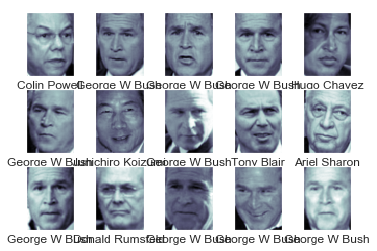

In [142]:
fig, ax = plt.subplots(3, 5) # 3 rows and 5 columns of images
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier. You will learn more about principal component analysis in the upcoming lectures. 

We can do PCA most straightforwardly by packaging the preprocessor and the classifier into a single sklearn pipeline:

In [143]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [144]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [1]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)


ModuleNotFoundError: No module named 'sklearn.grid_search'

The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [146]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

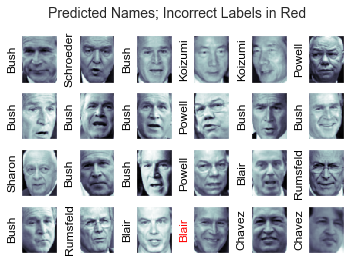

In [147]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [148]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.87      0.72        15
     Colin Powell       0.85      0.90      0.87        68
  Donald Rumsfeld       0.76      0.81      0.78        31
    George W Bush       0.98      0.82      0.89       126
Gerhard Schroeder       0.71      0.87      0.78        23
      Hugo Chavez       0.82      0.70      0.76        20
Junichiro Koizumi       0.80      1.00      0.89        12
       Tony Blair       0.87      0.95      0.91        42

      avg / total       0.87      0.85      0.86       337



We might also display the confusion matrix between these classes:

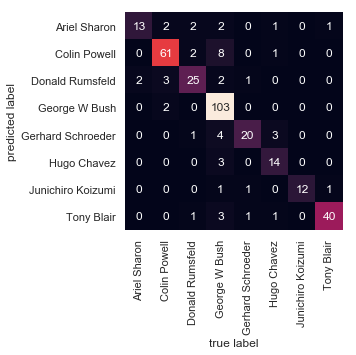

In [149]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

---
## <font color="#b51555">Exercise 1.10
Write a function that takes `ytest` and `yfit` as inputs and then calculates the precision metric by using the number of true positive and false positives.
  
$$precision = \frac{TP}{(FP+ TP)}$$
  
The precision for all the eight classes should be the same as the one obtained using the `classification_report` function.
<font>
---

In [150]:
def calculate_precision(yfit, ytest):
    TP = 0
    FP = 0

    for y in range(len(yfit)):
        if ytest[y] == yfit[y]:
            TP = TP + 1
        else:
            FP = FP + 1

    precision = TP/(TP + FP) * 100
    print("Precision: ", precision)
    return precision

# 2. Ensemble Learning


Suppose you ask a complex question to thousands of random people, then aggregate their answers. In
many cases you will find that this aggregated answer is better than an expert’s answer. This is called the
[wisdom of the crowd](https://www.youtube.com/watch?v=iOucwX7Z1HU). Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning.


### Voting Classifiers
Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a
Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors
classifier

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and
predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier. 
This voting classifier often achieves a higher accuracy than the best classifier in
the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than
random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there
are a sufficient number of weak learners and they are sufficiently diverse.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [67]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_features=1)
svm_clf = SVC(probability=True, random_state=42)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('rf', rnd_clf), 
                                          ('svc', svm_clf)],voting='soft')

In [68]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual classifiers.

---
## <font color="#b51555">Exercise 2.1
Change the 'voting' parameter from 'hard' to 'soft'. What happens to the accuracy of the voting classifier and why?
<font>
  
---

### Bagging Ensembles
One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
Another approach is to use the same training algorithm for every predictor, but to train them on different
random subsets of the training set. When sampling is performed with replacement, this method is called
bagging (short for bootstrap aggregating). Bagging allows training instances to be sampled several times for the same predictor.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply
aggregating the predictions of all predictors. The aggregation function is typically the statistical mode
(i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for
regression. Each individual predictor has a higher bias than if it were trained on the original training set,
but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a
similar bias but a lower variance than a single predictor trained on the original training set.

Let us train a bagging classifier of 500 decision trees and compare its performance to that of single tree:


In [69]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, 
                            bootstrap=True, 
                            n_jobs=-1, 
                            random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Let us check the performance of this bagging classifier:

In [70]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


Let us now see the performance of a simple decision tree:

In [71]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


As you can see, the bagging classifier (based on 500 decision trees) performs much better than a single descision tree alone.

---
## <font color="#b51555">Exercise 2.2
Use the abalone dataset from UCI
  https://archive.ics.uci.edu/ml/datasets/Abalone
and use apply AdaBoostClassifier, BaggingClassifier, RandomForest, and DecisionTreeClassifier and see which one gets the best performance. 
 
*HINTS:*
  
  You don't need to download the data as a file on your computer and then read it in Python. You can read in Python it directly from the data URL using the following code snippet:
  ```
import pandas as pd
import io
import requests
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
s = requests.get(url).content
  
# save the data in a dataframe
df = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None)
  ```
Now you have a pandas dataframe `df`, split it into `X` and `y`. `y` should contain the gender of the abalone.
  In the df, the sex of abalone is in the first column, and has three possible values: M (male), F (female), and I (Infant). Encode these as numbers (0, 1, and 2) using LabelEncoder in sklearn. Then split X, and y into train and test and use them for training and testing your classifiers.
  
<font>
  
---

In [72]:
import pandas as pd
import io
import requests
import numpy
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
s = requests.get(url).content

# save the data in a dataframe
df = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None)

y_df = numpy.array(df)[:,0]
X_df = numpy.array(df)[:, 1:]

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
import operator

le = LabelEncoder()

y_fit = le.fit_transform(y_df)

X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(
                        X_df, y_fit, test_size=0.33, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)

rnd_clf = RandomForestClassifier(random_state=42, 
                                 n_estimators=500, 
                                 max_features=1)

bag_clf = BaggingClassifier(n_estimators=500,
                            max_samples=100, 
                            bootstrap=True, 
                            n_jobs=-1, 
                            random_state=42)

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=42)

dt_clf.fit(X_df_train, y_df_train)
rnd_clf.fit(X_df_train, y_df_train)
bag_clf.fit(X_df_train, y_df_train)
ada_clf.fit(X_df_train, y_df_train)

dt_score = dt_clf.score(X_df_test, y_df_test)
rnd_score = rnd_clf.score(X_df_test, y_df_test)
bag_score = bag_clf.score(X_df_test, y_df_test)
ada_score = ada_clf.score(X_df_test, y_df_test)

dict = {
        "DecisionTreeClassifier": dt_score, 
        "RandomTreeClassifier": rnd_score,
        "BaggingClassifier": bag_score,
        "AdaBoostClassifier": ada_score,
        }

for keys, values in dict.items():
    print(keys,":  ", values)
    
print("Best classifier:", max(dict.items(), key=operator.itemgetter(1))[0])

DecisionTreeClassifier :   0.5068890500362582
RandomTreeClassifier :   0.5395213923132705
BaggingClassifier :   0.5467730239303843
AdaBoostClassifier :   0.5315445975344453
Best classifier: BaggingClassifier




---


## Sources and Attributions:
1. Python Data Science Handbook by Jake VanderPlas
2. Implementing a Weighted Majority Rule Ensemble Classifier in scikit-learn by Sebastian Raschka
3. 	Hands-On Machine Learning with Scikit-Learn and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems by Geron Aurelien


---

